In [1]:
import numpy as np
import math
from scipy.special import genlaguerre
from scipy.sparse import diags, kron, identity, csr_matrix
from scipy.sparse.linalg import expm_multiply
import matplotlib.pyplot as plt


In [2]:
# ===============================
# 1. Morse vibrational eigenstate
# ===============================
def morse_vibrational_wavefunction(r, D_e=0.1745, a=1.02, r_e=1.4,
                                   n=0, mu=918.076, hbar=1.0):
    """
    Morse vibrational eigenfunction psi_n(r) for an H2-like diatom.
    Parameters chosen to match the Kale–Kais / Weeks–Tannor setup
    (see their use of Morse basis for the diatomic slice). 
    All quantities in atomic units.
    """
    r = np.asarray(r, float)
    lam = math.sqrt(2.0 * mu * D_e) / (a*hbar)
    alpha = 2*lam - 2*n - 1
    z = 2*lam * np.exp(-a*(r - r_e))
    L = genlaguerre(n, alpha)
    N = math.sqrt(math.factorial(n) * (2*lam - 2*n - 1) * a /
                  math.gamma(2*lam - n))
    return N * (z**(lam-n-0.5)) * np.exp(-0.5*z) * L(z)

In [3]:
# =====================================
# 2. Channel wavepacket psi_in(R,r)
# =====================================
def psi_wavepacket(R, r, Delta_k, k0, R0, r_params):
    """
    Channel packet (reactant or product) as in Weeks–Tannor Eq.(8):
        psi_in(R,r) = psi_vib(r) * Gaussian(R) * plane_wave(R)

    R, r are arrays on the Jacobi-like grid mapped to bond coords.
    """
    psi_vib = morse_vibrational_wavefunction(r, **r_params)
    gaussian = np.exp(-(Delta_k**2) * (R - R0)**2)
    carrier  = np.exp(1j * k0 * (R - R0))
    pref = ((2*Delta_k**2)/np.pi)**0.25
    return pref * psi_vib * gaussian * carrier


In [4]:
# ================================
# 3. London potential on (X,Y)
# ================================
def morse_fun(r, De, beta, re):
    return De*(1 - np.exp(-beta*(r-re)))**2

def anti_morse_fun(r, De, beta, re):
    return 0.5*De*(np.exp(-2*beta*(r-re)) + 2*np.exp(-beta*(r-re)))

def london_energy_XY(X,Y,De,beta,re):
    """
    London-type 3-body energy in collinear bond coords (X,Y),
    similar to the potential model used in Kale–Kais SI:
       r12 = |X|, r23 = |Y|, r13 = r12 + r23
    """
    r12 = np.abs(X)
    r23 = np.abs(Y)
    r13 = r12 + r23

    Q1 = 0.5*(morse_fun(r12,De,beta,re) + anti_morse_fun(r12,De,beta,re))
    a1 = 0.5*(morse_fun(r12,De,beta,re) - anti_morse_fun(r12,De,beta,re))

    Q2 = 0.5*(morse_fun(r23,De,beta,re) + anti_morse_fun(r23,De,beta,re))
    a2 = 0.5*(morse_fun(r23,De,beta,re) - anti_morse_fun(r23,De,beta,re))

    Q3 = 0.5*(morse_fun(r13,De,beta,re) + anti_morse_fun(r13,De,beta,re))
    a3 = 0.5*(morse_fun(r13,De,beta,re) - anti_morse_fun(r13,De,beta,re))

    t1 = (a1 - a2)**2
    t2 = (a1 - a3)**2
    t3 = (a3 - a2)**2

    return Q1 + Q2 + Q3 - (1/np.sqrt(2))*np.sqrt(t1 + t2 + t3)

In [5]:
# ============================================
# 4. Kinetic operator T on (X,Y) grid (sparse)
# ============================================
def build_XY_kinetic(X, Y, mH=918.076):
    """
    Kinetic operator in bond coordinates (collinear H3),
    following Baer’s coupled-bond coordinates as in Eq.(4) of
    Weeks–Tannor (Laplacian + mixed derivative term).

    T = (1/mH)[ 0.5(-∂_XX - ∂_YY) + mixed-term ]
    """
    NX, NY = len(X), len(Y)
    dX = X[1] - X[0]
    dY = Y[1] - Y[0]

    Dx  = diags([-0.5/dX, 0, 0.5/dX], [-1,0,1], shape=(NX,NX))
    Dy  = diags([-0.5/dY, 0, 0.5/dY], [-1,0,1], shape=(NY,NY))
    Dxx = diags([1/dX**2,-2/dX**2,1/dX**2],[-1,0,1],shape=(NX,NX))
    Dyy = diags([1/dY**2,-2/dY**2,1/dY**2],[-1,0,1],shape=(NY,NY))

    Ix = identity(NX)
    Iy = identity(NY)

    lap   = -kron(Dxx,Iy) - kron(Ix,Dyy)  # -∂_XX - ∂_YY
    cross = -kron(Dx, Dy)                 # mixed derivative

    return (0.5*lap + cross)/mH


In [6]:
# ======================
# 5. Build grid & H
# ======================
NX = NY = 32         # you can increase later; 32×32 matches Kale–Kais tests well
Xmax = Ymax = 5.0
X = np.linspace(0, Xmax, NX)
Y = np.linspace(0, Ymax, NY)
dx, dy = X[1]-X[0], Y[1]-Y[0]
Xg, Yg = np.meshgrid(X, Y, indexing="ij")

# Potential (London-like, same parameters as in your notebook)
De   = 0.174   # Hartree
beta = 1.028
re   = 1.41
V_XY = london_energy_XY(Xg, Yg, De, beta, re)
V_op = diags(V_XY.reshape(-1), 0, format="csr")

# Kinetic + total H
T  = build_XY_kinetic(X, Y, mH=918.076)
H  = (T + V_op).tocsr()


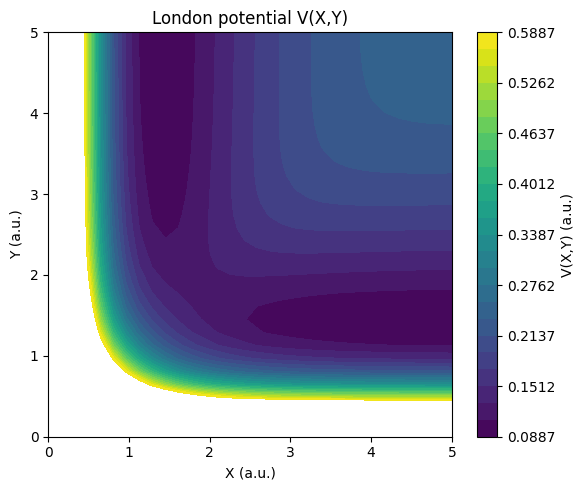

In [7]:
# ==========================
# 6. Plot potential V(X,Y)
# ==========================
plt.figure(figsize=(6,5))
levels = np.linspace(np.min(V_XY), np.min(V_XY)+0.5, 25)  # focus near well
cs = plt.contourf(Xg, Yg, V_XY, levels=levels)
plt.colorbar(cs, label="V(X,Y) (a.u.)")
plt.xlabel("X (a.u.)"); plt.ylabel("Y (a.u.)")
plt.title("London potential V(X,Y)")
plt.tight_layout()
plt.show()

In [8]:
# =============================================
# 7. Reactant & product wavepackets on (X,Y)
# =============================================
# Parameters chosen to match Weeks–Tannor text (Gaussian in Rk)
Delta_k = 1.25
R0      = 2.25
k0_re   = -8.2   # incoming reactant momentum
k0_pr   = +8.2   # outgoing product momentum

# Channel mapping (Eq.(3) in Weeks–Tannor: Jacobi -> bond coords)
# Reactant: (r1,R1), Product: (r2,R2)
r1 = Yg
R1 = Xg + 0.5*Yg      # arrangement channel 1
r2 = Xg
R2 = Yg + 0.5*Xg      # arrangement channel 2

r_params = dict(D_e=0.1745, a=1.02, r_e=1.4, mu=918.076, hbar=1.0)

# Reactant channel packet (v=0), localized ~ interaction region -> acts as Ψ^+_0
psi_react = psi_wavepacket(R1, r1, Delta_k, k0_re, R0,
                           {**r_params, 'n':0})
norm_r = np.sqrt((np.abs(psi_react)**2).sum()*dx*dy)
psi_react /= norm_r

# Product channel packets (v' = 0,1,2) → Ψ^-_{v'} at t=0
psi_prod_list = []
for vprime in [0,1,2]:
    psi = psi_wavepacket(R2, r2, Delta_k, k0_pr, R0,
                         {**r_params, 'n':vprime})
    norm_p = np.sqrt((np.abs(psi)**2).sum()*dx*dy)
    psi /= norm_p
    psi_prod_list.append(psi)
psi_prod = np.array(psi_prod_list)  # shape (3, NX, NY)

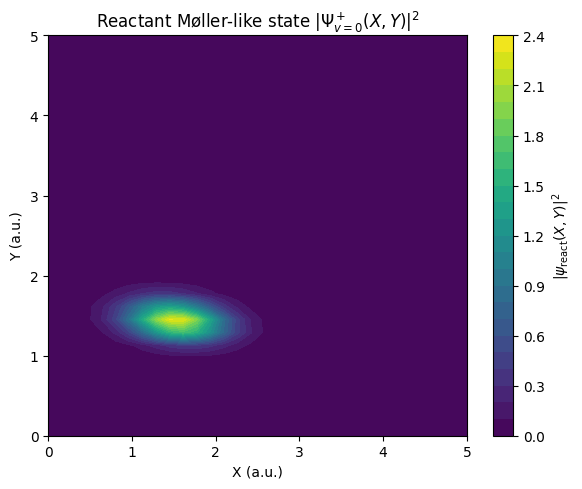

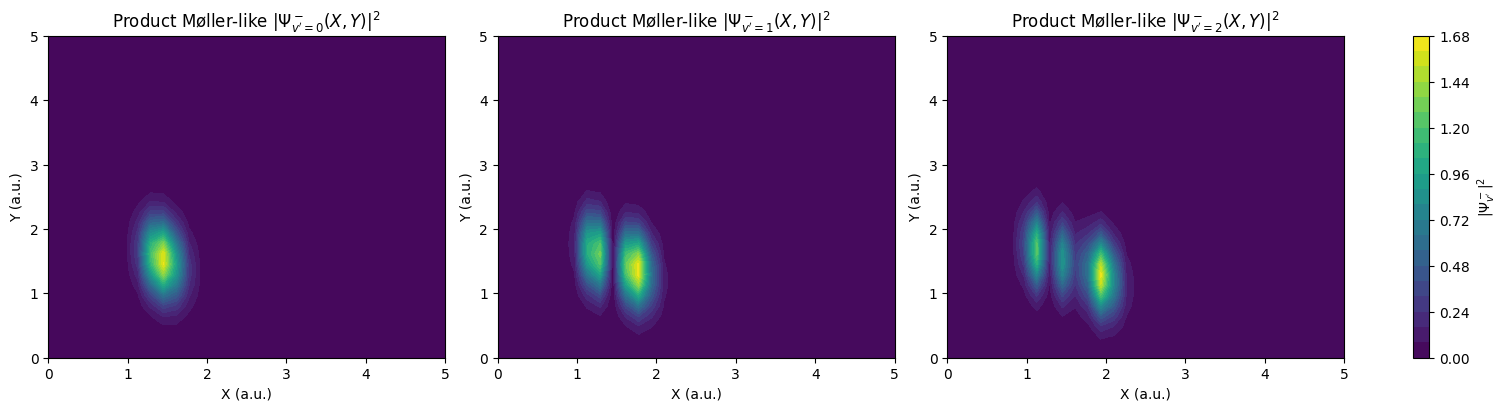

Overlap matrix <psi_v'|psi_v''> (approx):
[[ 1.00000000e+00+0.00000000e+00j -3.81344182e-05+8.40216074e-18j
  -2.00370931e-05-1.36466164e-17j]
 [-3.81344182e-05-8.40216074e-18j  1.00000000e+00+0.00000000e+00j
  -1.02905984e-04-3.00120314e-18j]
 [-2.00370931e-05+1.36466164e-17j -1.02905984e-04+3.00120314e-18j
   1.00000000e+00+0.00000000e+00j]]


In [9]:
# ================
# 8. Plot wavepackets
# ================
# Reactant |psi|^2
plt.figure(figsize=(6,5))
plt.contourf(Xg, Yg, np.abs(psi_react)**2, levels=25)
plt.colorbar(label=r"$|\psi_{\rm react}(X,Y)|^2$")
plt.xlabel("X (a.u.)"); plt.ylabel("Y (a.u.)")
plt.title("Reactant Møller-like state $|\\Psi^+_{v=0}(X,Y)|^2$")
plt.tight_layout()
plt.show()

# Product |psi_v'|^2
fig, axes = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
for ax, vp in zip(axes, [0,1,2]):
    im = ax.contourf(Xg, Yg, np.abs(psi_prod[vp])**2, levels=25)
    ax.set_xlabel("X (a.u.)")
    ax.set_ylabel("Y (a.u.)")
    ax.set_title(fr"Product Møller-like $|\Psi^-_{{v'={vp}}}(X,Y)|^2$")
fig.colorbar(im, ax=axes.ravel().tolist(), label=r"$|\Psi^-_{v'}|^2$")
plt.show()

# Overlap diagnostics between product channels (should be ~δ_{v'v''})
psi_p_flat = psi_prod.reshape(3, -1)
S_overlap = psi_p_flat @ psi_p_flat.conj().T * dx*dy
print("Overlap matrix <psi_v'|psi_v''> (approx):")
print(S_overlap)

In [10]:
# ===============================
# 9. Time-dependent correlation C(t)
# ===============================
# C_{v',0}(t) = <Psi^-_{v'}| e^{-iHt} |Psi^+_0>
# using the correct inner product with dx*dy measure.

psi_r_flat = psi_react.reshape(-1)     # |Ψ^+_0>
# psi_prod is shape (3, NX, NY)

t_min = -1000.0
t_max =  4000.0
Nt    = 400
ts_full = np.linspace(t_min, t_max, Nt)

C_full = np.zeros((Nt, 3), dtype=complex)

for i, t in enumerate(ts_full):
    # evolve reactant wavepacket
    psi_t_flat = expm_multiply(-1j * H * t, psi_r_flat)

    # reshape to grid for proper integration measure
    psi_t = psi_t_flat.reshape(NX, NY)

    for vp in range(3):
        psi_p = psi_prod[vp]    # shape (NX, NY)
        # correct Hilbert-space inner product on the grid
        C_full[i, vp] = np.sum(np.conjugate(psi_p) * psi_t) * dx * dy


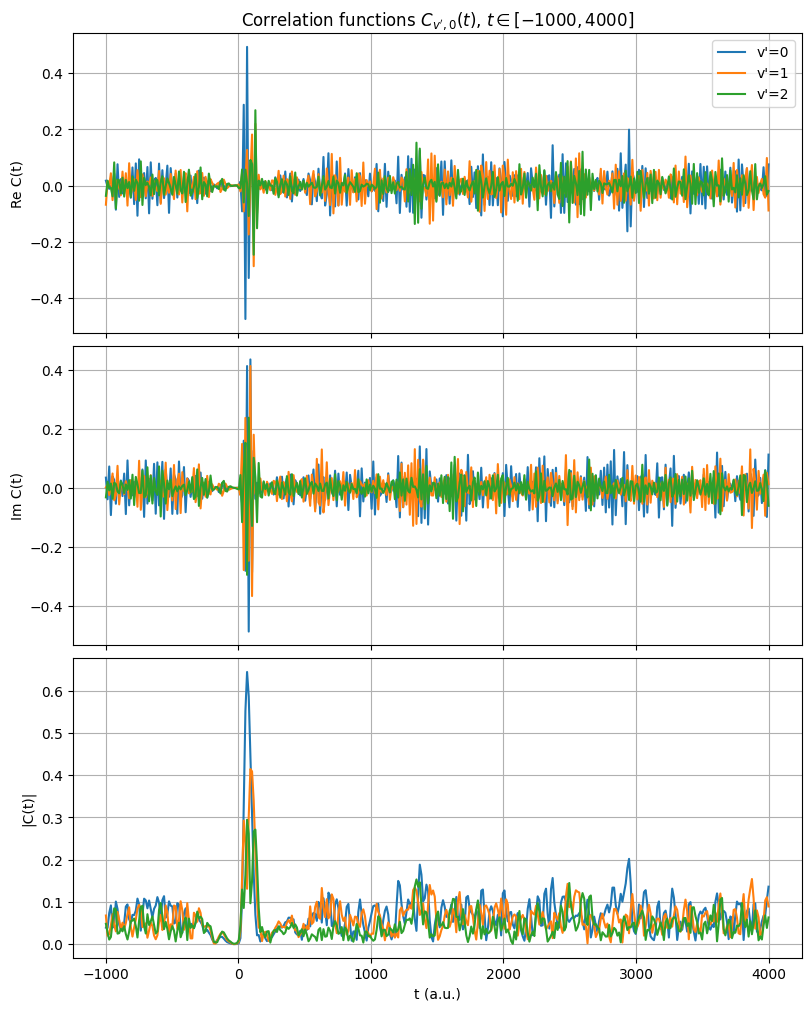

In [11]:
# ==============================
# 10. Plot C(t): Re, Im, |C|
# ==============================
fig, axes = plt.subplots(3,1, figsize=(8,10), sharex=True, constrained_layout=True)
labels = [r"v'=0", r"v'=1", r"v'=2"]

for j in range(3):
    axes[0].plot(ts_full, C_full[:,j].real, label=labels[j])
    axes[1].plot(ts_full, C_full[:,j].imag, label=labels[j])
    axes[2].plot(ts_full, np.abs(C_full[:,j]), label=labels[j])

axes[0].set_ylabel("Re C(t)")
axes[1].set_ylabel("Im C(t)")
axes[2].set_ylabel("|C(t)|")
axes[2].set_xlabel("t (a.u.)")

for ax in axes:
    ax.grid(True)
axes[0].set_title(r"Correlation functions $C_{v',0}(t)$, $t\in[-1000,4000]$")
axes[0].legend()
plt.show()

In [12]:
from scipy.sparse.linalg import expm_multiply

psi_r_flat = psi_react.reshape(-1)

t_min = -1000.0
t_max =  4000.0
Nt    = 400
ts_full = np.linspace(t_min, t_max, Nt)

C_rr = np.zeros(Nt, dtype=complex)

for i, t in enumerate(ts_full):
    psi_t_flat = expm_multiply(-1j * H * t, psi_r_flat)
    psi_t = psi_t_flat.reshape(NX, NY)
    C_rr[i] = np.sum(np.conjugate(psi_react) * psi_t) * dx * dy


In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

HARTREE_TO_EV = 27.2114
def fft_C_to_F(ts, C, zero_pad=8):
    """
    Your 'bare spectrum' FFT:
      - symmetrize time grid
      - Hann window
      - zero padding
      - FFT with fftshift
      - keep E>=0
    Returns E_eV (1D) and F(E) (1D complex).
    """
    ts = np.asarray(ts, float)
    C  = np.asarray(C, complex)
    dt = ts[1] - ts[0]

    # symmetrize as in your snippet
    tmin, tmax = ts.min(), ts.max()
    if abs(abs(tmin) - abs(tmax)) > 1e-12:
        T   = max(abs(tmin), abs(tmax))
        N   = len(ts)
        ts2 = np.linspace(-T, T, N)
        C   = np.interp(ts2, ts, C)
        ts  = ts2
        dt  = ts[1] - ts[0]

    n = len(ts)
    # Hann window
    w  = 0.5 - 0.5*np.cos(2*np.pi*np.arange(n)/(n-1))
    Cw = C * w

    # zero padding
    Npad = int(2**np.ceil(np.log2(n * zero_pad)))
    pad  = Npad - n
    Cw   = np.pad(Cw, (pad//2, pad - pad//2))

    F = np.fft.fftshift(np.fft.fft(Cw)) * dt
    freqs = np.fft.fftshift(np.fft.fftfreq(Npad, d=dt))

    E_au = 2*np.pi*freqs      # ħ=1
    E_eV = E_au * HARTREE_TO_EV

    keep = (E_au >= 0)
    return E_eV[keep], F[keep]


In [14]:
import numpy as np

HARTREE_TO_EV = 27.2114

def scattering_from_C_classical7(
    ts,
    C_full,
    mu_R=918.076,
    E_min_eV=0.4,
    E_max_eV=2.4,
    nE=400,
    E_vp_eV=(0.0, 0.47, 0.94),
):
    """
    Fixed–energy transform and flux prefactor exactly as in Classical (7):

      1. subtract long–time offset from C_{v',0}(t)
      2. apply Hann window over full time interval
      3. compute S̃_{v',0}(E) = ∫ dt e^{-iEt} C_{v',0}(t)
      4. multiply by flux prefactor sqrt(|k_r k_p|)/(2π μ_R)
      5. P_{v',0}(E) = |S_{v',0}(E)|^2 and scale global max → 1

    This should reproduce the scattering curves from your 4-panel
    “Classical vs Quantum” figure.
    """

    ts = np.asarray(ts, float)            # (Nt,)
    C_full = np.asarray(C_full, complex)  # (Nt, 3)
    Nt, n_chan = C_full.shape

    # ----- Energy grid (in a.u.) -----
    E_grid_eV = np.linspace(E_min_eV, E_max_eV, nE)
    E_grid = E_grid_eV / HARTREE_TO_EV   # Hartree

    # ----- Use full time interval -----
    t_use = ts.copy()
    C_use = C_full.copy()
    Nt_use = len(t_use)

    # ----- Subtract long–time offset so C(t) → 0 for large t -----
    # use last 20% of times as "tail" window
    tail_mask = t_use > (t_use.min() + 0.8*(t_use.max() - t_use.min()))
    for vp in range(n_chan):
        C_offset = C_use[tail_mask, vp].mean()
        C_use[:, vp] -= C_offset

    # ----- Hann window across entire time interval -----
    hann = 0.5 * (1.0 - np.cos(2.0*np.pi*np.arange(Nt_use)/(Nt_use - 1)))
    C_win = C_use * hann[:, None]

    # ----- Energy integral: S̃(E) = ∫ dt e^{-iEt} C(t) -----
    S_tilde = np.zeros((len(E_grid), n_chan), dtype=complex)
    for vp in range(n_chan):
        Cj = C_win[:, vp]                 # (Nt_use,)
        phase = np.exp(-1j * np.outer(E_grid, t_use))  # (nE, Nt_use)
        integrand = phase * Cj[None, :]
        S_tilde[:, vp] = np.trapz(integrand, t_use, axis=1)

    # ----- Flux prefactor and probabilities (exactly your old code) -----
    E_vp = np.array(E_vp_eV) / HARTREE_TO_EV
    E_v = 0.0

    def k_react(E):
        E = np.asarray(E)
        # sign doesn't matter, we use |k_r k_p| inside sqrt
        return -np.sqrt(2.0 * mu_R * np.maximum(E - E_v, 0.0))

    def k_prod(E, vp):
        E = np.asarray(E)
        return +np.sqrt(2.0 * mu_R * np.maximum(E - E_vp[vp], 0.0))

    S_E = np.zeros_like(S_tilde, dtype=complex)
    for vp in range(n_chan):
        k  = k_react(E_grid)
        kp = k_prod(E_grid, vp)
        F = np.zeros_like(E_grid)
        mask = (kp > 0) & (np.abs(k) > 0)
        F[mask] = np.sqrt(np.abs(k[mask] * kp[mask])) / (2.0*np.pi*mu_R)
        S_E[:, vp] = F * S_tilde[:, vp]

    P_E = np.abs(S_E)**2
    P_E /= P_E.max()  # global max → 1, as in Classical (7)

    return E_grid_eV, P_E


In [15]:
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

HARTREE_TO_EV = 27.2114  # if not already defined

def morse_potential_1d(r, D_e=0.1745, a=1.02, r_e=1.4):
    """1D Morse potential V(r) in atomic units."""
    r = np.asarray(r, float)
    return D_e * (1.0 - np.exp(-a * (r - r_e)))**2

def morse_vibrational_levels(D_e=0.1745, a=1.02, r_e=1.4,
                             mu=918.076,
                             r_min=0.3, r_max=5.0,
                             Nr=1024, n_levels=3):
    """
    Diagonalize a 1D Morse Hamiltonian to get the lowest vibrational
    energies E0, E1, ... (in Hartree).

    Parameters
    ----------
    D_e, a, r_e : Morse parameters (same as you use in LEPS asymptotics)
    mu          : reduced mass (H2) in a.u.
    r_min,max   : radial grid limits
    Nr          : number of grid points
    n_levels    : number of eigenvalues to return
    """
    r = np.linspace(r_min, r_max, Nr)
    dr = r[1] - r[0]

    # kinetic: -1/(2µ) d^2/dr^2 with Dirichlet BC
    main = np.full(Nr, -2.0)
    off  = np.ones(Nr-1)
    Lap  = diags([off, main, off], [-1, 0, 1]) / (dr**2)
    T1D  = -(1.0 / (2.0 * mu)) * Lap.tocsr()

    V1D  = diags(morse_potential_1d(r, D_e=D_e, a=a, r_e=r_e), 0)
    H1D  = (T1D + V1D).tocsr()

    evals, evecs = eigsh(H1D, k=n_levels, which="SA")
    evals = np.sort(evals.real)
    return r, evals, evecs


In [16]:
# once, somewhere above
HARTREE_TO_EV = 27.2114

r, evals, _ = morse_vibrational_levels(
    D_e=De, a=beta, r_e=re,
    mu=918.076, r_min=0.3, r_max=5.0, Nr=1024, n_levels=3
)
E0, E1, E2 = evals
E_vp_eV = (0.0,
           (E1-E0)*HARTREE_TO_EV,
           (E2-E0)*HARTREE_TO_EV)


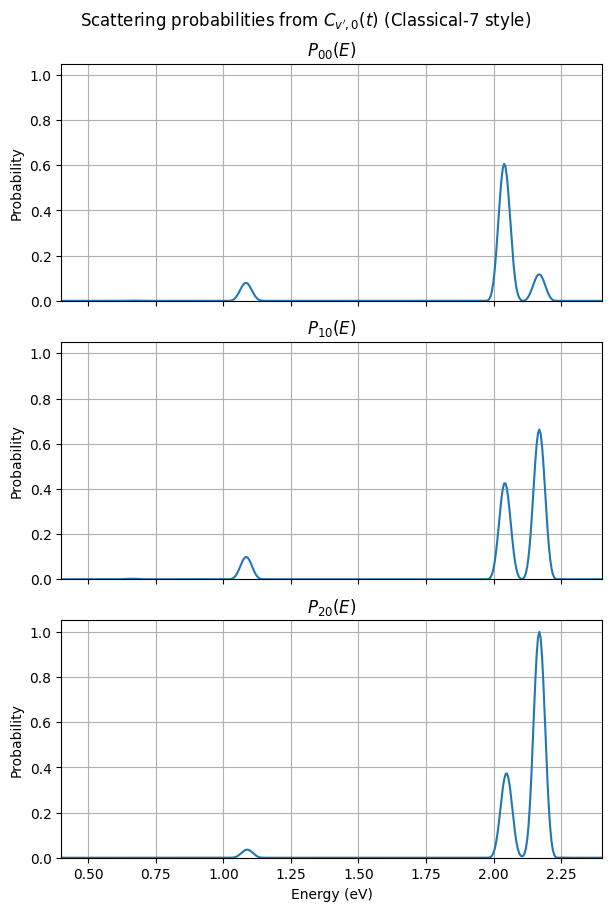

In [17]:
# Use the same Morse thresholds you used for the 4-panel figure.
# If you already computed them via morse_vibrational_levels, pass that tuple here.
E_vp_eV = (0.0, 0.5133, 0.9952)  # or (0.0, 0.47, 0.94) – whichever you used before
mu_R = 918.076   # reduced mass used in your R-kinetic operator (a.u.)

E_eV, P_E = scattering_from_C_classical7(
    ts_full,
    C_full,          # shape (Nt, 3), C_{v',0}(t)
    mu_R=mu_R,       # same mu_R as in your H+H2 Hamiltonian
    E_min_eV=0.4,
    E_max_eV=2.4,
    nE=400,
    E_vp_eV=E_vp_eV,
)

P00, P10, P20 = P_E.T

fig, axes = plt.subplots(3,1, figsize=(6,9), sharex=True, constrained_layout=True)
labels = [r"$P_{00}(E)$", r"$P_{10}(E)$", r"$P_{20}(E)$"]

for vp, ax in enumerate(axes):
    ax.plot(E_eV, P_E[:, vp])
    ax.set_xlim(0.4, 2.4)
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel("Probability")
    ax.set_title(labels[vp])
    ax.grid(True)

axes[-1].set_xlabel("Energy (eV)")
plt.suptitle(r"Scattering probabilities from $C_{v',0}(t)$ (Classical-7 style)")
plt.show()


In [18]:
print("max |sum_v P(E) - 1| =", np.max(np.abs(P.sum(axis=1) - 1)))


NameError: name 'P' is not defined